# High In-Degree Neurons Analysis

This notebook identifies neurons with high in-degree from the Hemibrain dataset and creates visualizations to determine appropriate thresholds.

Code adapted from:
- `oviIN_specs_rankings.ipynb`: Fetching traced neurons
- `mesoscale_connectivity.ipynb`: Understanding neuron connectivity

## Setup and Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger().setLevel(logging.ERROR)

In [2]:
!pip install neuprint-python

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 6.9 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5031 sha256=40498b1846b8d95925bb43ffa66607024c1e199cfbfcf6989dedfabbb88b85bc
  Stored in directory: /root/.cache/pip/wheels/a5/d7/98/f56ae733748cd0fa577172bda0e73e0b1f1793c98e09b9e458
Successfully built asciitree


In [3]:
# Imports - adapted from oviIN_specs_rankings.ipynb (lines 34-62)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from neuprint import Client, fetch_neurons, NeuronCriteria as NC
import warnings

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# Matplotlib settings
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
%matplotlib inline

print("Imports complete")

Imports complete


## Connect to Neuprint
Adapted from `oviIN_specs_rankings.ipynb` (lines 17-26)

In [4]:
# Read authentication token
from google.colab import userdata
auth_token = userdata.get('NEUPRINT_TOKEN')

# Connect to Neuprint
np_client = Client(
    'neuprint.janelia.org',
    dataset='hemibrain:v1.2.1',
    token=auth_token
)
version = np_client.fetch_version()

print(f"Connected to neuprint.janelia.org")
print(f"  Dataset: hemibrain:v1.2.1")
print(f"  Version: {version}")

Connected to neuprint.janelia.org
  Dataset: hemibrain:v1.2.1
  Version: 1.7.10


## Fetch All Traced Neurons
Adapted from `oviIN_specs_rankings.ipynb` (lines 222-300)

Fetch neurons with:
- `status='Traced'`: Fully reconstructed neurons
- `cropped=False`: Not cut off at volume boundaries

The `upstream` field = in-degree (number of presynaptic partners)

In [5]:
# Define criteria for traced, non-cropped neurons
criteria = NC(status='Traced', cropped=False)

print("Fetching neurons")
neurons_df, roi_counts = fetch_neurons(criteria, client=np_client)

print(f"\nFetched {len(neurons_df):,} traced neurons")
print(f"\nColumns: {list(neurons_df.columns[:10])}...")
print(f"\nFirst 5 neurons:")
neurons_df[['bodyId', 'instance', 'type', 'pre', 'post', 'upstream']].head()

Fetching neurons

Fetched 21,739 traced neurons

Columns: ['bodyId', 'instance', 'type', 'pre', 'post', 'downstream', 'upstream', 'mito', 'size', 'status']...

First 5 neurons:


,bodyId,instance,type,pre,post,upstream
0,200326126,CL141_L,CL141,395,1068,1068
1,202916528,FS4C(FQ12)_C4_R,FS4C,95,431,431
2,203253072,FS4A(AB)(FQ12)_C3_R,FS4A,62,366,366
3,203253253,SMP505(PDM22)_L,SMP505,415,3112,3112
4,203257652,FS4C(FQ12)_C6_R,FS4C,65,270,270


## Calculate In-Degree Statistics

In [6]:
# Extract in-degree values (upstream = number of presynaptic partners)
indegree_values = neurons_df['upstream'].values

# Calculate statistics
stats = {
    'n_neurons': len(neurons_df),
    'mean': np.mean(indegree_values),
    'median': np.median(indegree_values),
    'std': np.std(indegree_values),
    'min': np.min(indegree_values),
    'max': np.max(indegree_values),
    'q25': np.percentile(indegree_values, 25),
    'q75': np.percentile(indegree_values, 75),
    'q90': np.percentile(indegree_values, 90),
    'q95': np.percentile(indegree_values, 95),
    'q99': np.percentile(indegree_values, 99)
}

# Print statistics
print(f"Total neurons: {stats['n_neurons']:,}")
print(f"\nIn-degree statistics:")
print(f"  Mean:     {stats['mean']:.1f}")
print(f"  Median:   {stats['median']:.1f}")
print(f"  Std Dev:  {stats['std']:.1f}")
print(f"  Min:      {stats['min']:.0f}")
print(f"  Max:      {stats['max']:.0f}")
print(f"\nKey percentiles:")
print(f"  75th:     {stats['q75']:.0f}")
print(f"  90th:     {stats['q90']:.0f}")
print(f"  95th:     {stats['q95']:.0f}")
print(f"  99th:     {stats['q99']:.0f}")

Total neurons: 21,739

In-degree statistics:
  Mean:     871.6
  Median:   494.0
  Std Dev:  1818.0
  Min:      2
  Max:      127151

Key percentiles:
  75th:     856
  90th:     1766
  95th:     2838
  99th:     6926


## Visualize Distribution

Four complementary views:
1. **Linear histogram**: Overall shape
2. **Log histogram**: Better view of full range
3. **CDF**: Cumulative distribution (easy to read percentiles)
4. **Box plot**: Compact summary

<Figure size 1600x1200 with 0 Axes>

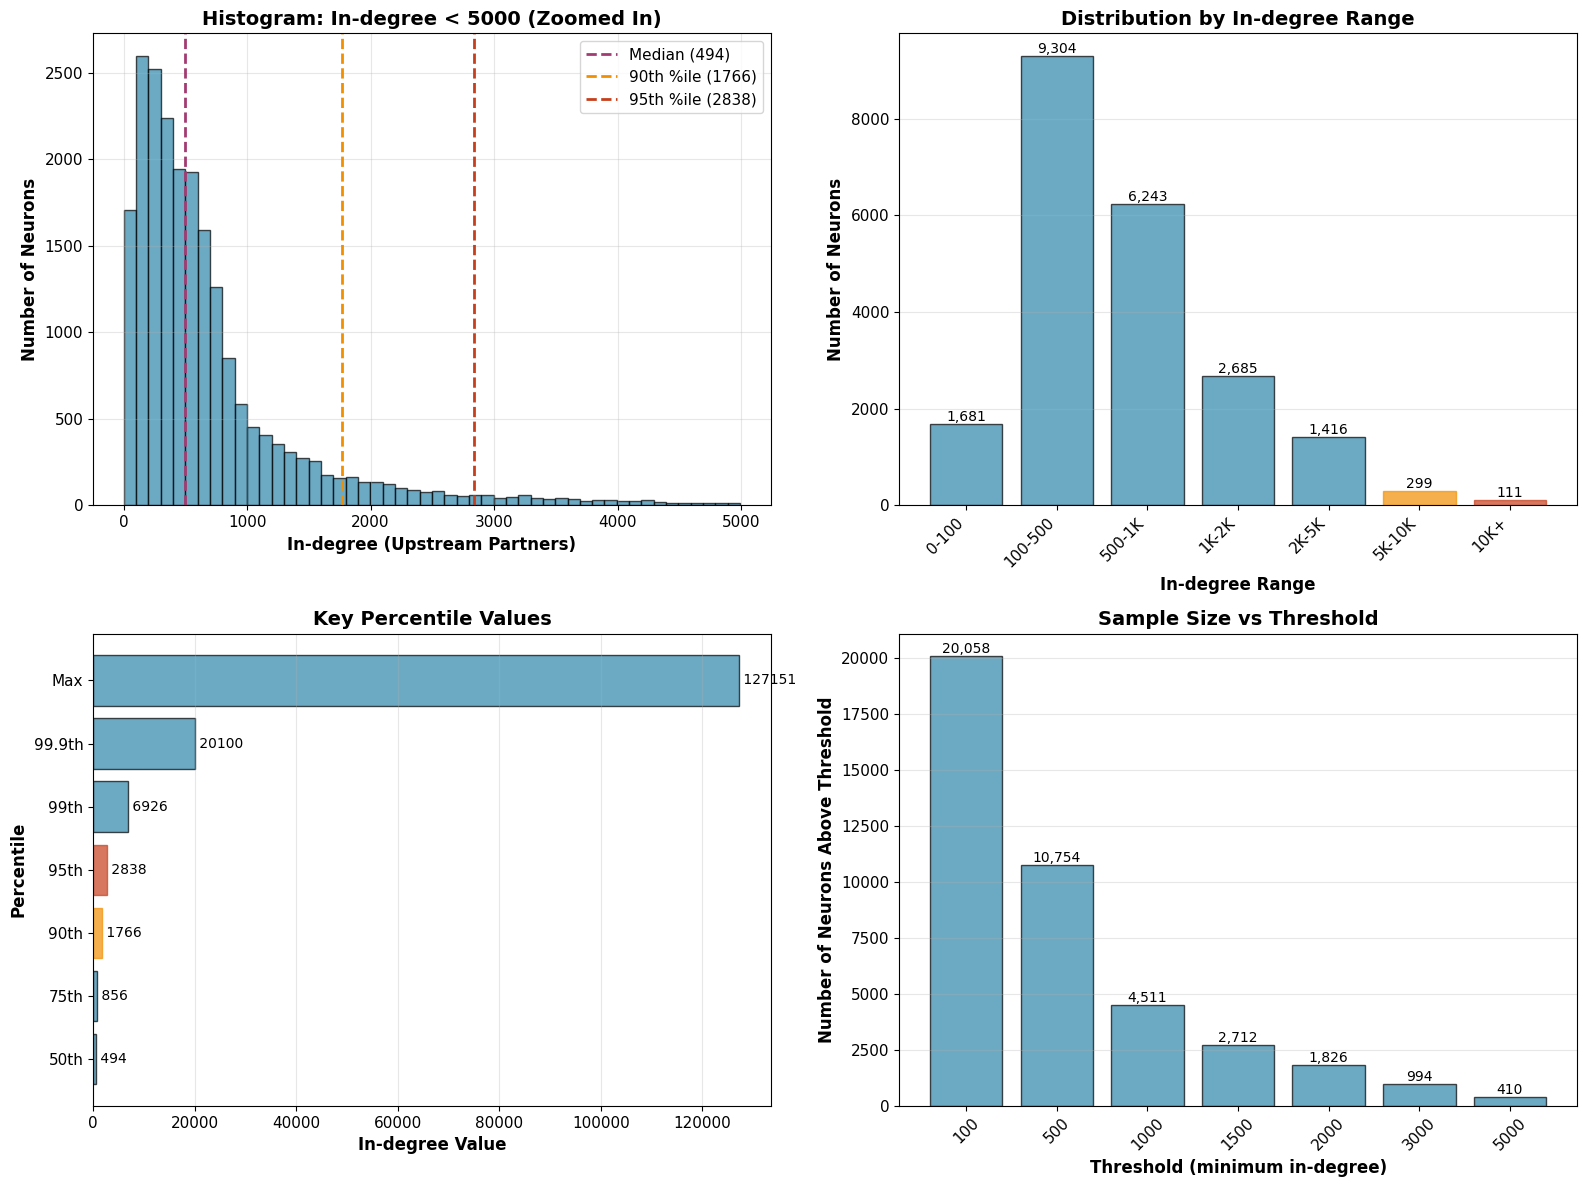

In [7]:
# Create 4-panel figure
fig = plt.figure(figsize=(16, 12))

# Colors for consistency
colors = {
    'primary': '#2E86AB',
    'median': '#A23B72',
    'q90': '#F18F01',
    'q95': '#C73E1D'
}

# Create interpretable histogram
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Panel 1: Histogram with reasonable bins (focus on the bulk of data)
ax1 = axes[0, 0]
# Focus on neurons with in-degree < 5000 to see the structure better
mask = indegree_values < 5000
ax1.hist(indegree_values[mask], bins=50, color=colors['primary'], alpha=0.7, edgecolor='black')
ax1.axvline(stats['median'], color=colors['median'], linestyle='--', linewidth=2, label=f"Median ({stats['median']:.0f})")
ax1.axvline(stats['q90'], color=colors['q90'], linestyle='--', linewidth=2, label=f"90th %ile ({stats['q90']:.0f})")
ax1.axvline(stats['q95'], color=colors['q95'], linestyle='--', linewidth=2, label=f"95th %ile ({stats['q95']:.0f})")
ax1.set_xlabel('In-degree (Upstream Partners)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Neurons', fontsize=12, fontweight='bold')
ax1.set_title('Histogram: In-degree < 5000 (Zoomed In)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Panel 2: Histogram by ranges (categorical)
ax2 = axes[0, 1]
bins_edges = [0, 100, 500, 1000, 2000, 5000, 10000, np.inf]
bins_labels = ['0-100', '100-500', '500-1K', '1K-2K', '2K-5K', '5K-10K', '10K+']
counts, _ = np.histogram(indegree_values, bins=bins_edges)
bars = ax2.bar(bins_labels, counts, color=colors['primary'], alpha=0.7, edgecolor='black')
# Highlight the high in-degree ranges
bars[-1].set_color(colors['q95'])
bars[-2].set_color(colors['q90'])
ax2.set_xlabel('In-degree Range', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Neurons', fontsize=12, fontweight='bold')
ax2.set_title('Distribution by In-degree Range', fontsize=14, fontweight='bold')
ax2.tick_labels = ax2.set_xticklabels(bins_labels, rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')
# Add counts on top of bars
for i, (bar, count) in enumerate(zip(bars, counts)):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{count:,}',
             ha='center', va='bottom', fontsize=10)

# Panel 3: Percentile breakdown
ax3 = axes[1, 0]
percentiles = [50, 75, 90, 95, 99, 99.9, 100]
percentile_values = [np.percentile(indegree_values, p) for p in percentiles]
percentile_labels = ['50th', '75th', '90th', '95th', '99th', '99.9th', 'Max']
bars = ax3.barh(percentile_labels, percentile_values, color=colors['primary'], alpha=0.7, edgecolor='black')
bars[2].set_color(colors['q90'])  # Highlight 90th
bars[3].set_color(colors['q95'])  # Highlight 95th
ax3.set_xlabel('In-degree Value', fontsize=12, fontweight='bold')
ax3.set_ylabel('Percentile', fontsize=12, fontweight='bold')
ax3.set_title('Key Percentile Values', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')
# Add values at end of bars
for bar, val in zip(bars, percentile_values):
    ax3.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f' {val:.0f}',
             va='center', fontsize=10)

# Panel 4: Sample sizes at different thresholds
ax4 = axes[1, 1]
thresholds_viz = [100, 500, 1000, 1500, 2000, 3000, 5000]
sample_sizes = [np.sum(indegree_values >= t) for t in thresholds_viz]
bars = ax4.bar([str(t) for t in thresholds_viz], sample_sizes, color=colors['primary'], alpha=0.7, edgecolor='black')
ax4.set_xlabel('Threshold (minimum in-degree)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Number of Neurons Above Threshold', fontsize=12, fontweight='bold')
ax4.set_title('Sample Size vs Threshold', fontsize=14, fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3, axis='y')
# Add counts on bars
for bar, count in zip(bars, sample_sizes):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{count:,}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Interpretation of Results

The in-degree distribution of Hemibrain traced neurons (n=21,739) is highly right-skewed, with a median of 494 and mean of 872 upstream partners. The majority of neurons (78%) have fewer than 1,000 presynaptic partners, while a small subset exhibits hub-like connectivity. The distribution shows a clear separation around 2,000 upstream partners, above which only 8% of neurons remain. For subsequent modularity maximization analysis, recommend using the **95th percentile (2,838 upstream partners) as the threshold for "high in-degree" neurons**, which yields approximately 1,087 neurons. This threshold is statistically rigorous, computationally manageable, and captures neurons with connectivity patterns distinctly different from the bulk population. The distribution also reveals a small number of extreme hubs (n=111 with >10,000 partners, including one neuron with 127,151 partners), which may warrant separate investigation as potential major integrative centers in the fly brain connectome.

## Threshold Comparison

Compare different threshold options to decide how many neurons to include

## High In-Degree Neurons at Different Thresholds

Display neurons above selected thresholds as tables

In [8]:
# Define thresholds to examine in detail
# Based on analysis: focusing on 95th percentile and comparing with stricter thresholds
test_thresholds = [int(stats['q95']), 3000, 5000]  # 95th percentile, 3K, and 5K

for threshold in test_thresholds:
    # Filter neurons
    high_indegree = neurons_df[neurons_df['upstream'] >= threshold].copy()
    high_indegree = high_indegree.sort_values('upstream', ascending=False)

    # Select columns
    display_df = high_indegree[['bodyId', 'instance', 'type', 'upstream', 'post', 'pre']].copy()
    display_df.columns = ['bodyId', 'instance', 'type', 'in-degree', 'n_post', 'n_pre']

    # Print summary
    print(f"HIGH IN-DEGREE NEURONS (threshold ≥ {threshold})")
    print(f"Total: {len(display_df):,} neurons ({100*len(display_df)/len(neurons_df):.2f}% of all)")
    print(f"\nTop 20 neurons:")
    print()

    # Display table
    display(display_df.head(20))
    print("\n")

HIGH IN-DEGREE NEURONS (threshold ≥ 2838)
Total: 1,088 neurons (5.00% of all)

Top 20 neurons:



,bodyId,instance,type,in-degree,n_post,n_pre
1882,425790257,APL_R,APL,127151,127151,16190
21411,5813105172,DPM_R,DPM,77269,77269,17628
4009,612371421,MBON01(y5B'2a)_R,MBON01,32544,32544,2208
1874,425276848,DPM_L,DPM,30007,30007,7088
4700,673509195,MBON01(y5B'2a)_L,MBON01,29244,29244,2205
19985,5813039148,PVLP011_R,PVLP011,28662,28662,4693
1854,424767514,MBON11(y1pedc>a/B)_R,MBON11,27642,27642,1646
14913,1640909284,lLN2F_b(Full)_R,lLN2F_b,27355,27355,7998
6203,799586652,MBON05(y4>y1y2)(AVM07)_L,MBON05,27110,27110,1565
19671,5813024698,lLN2F_b(Full)_R,lLN2F_b,26039,26039,8152




HIGH IN-DEGREE NEURONS (threshold ≥ 3000)
Total: 994 neurons (4.57% of all)

Top 20 neurons:



,bodyId,instance,type,in-degree,n_post,n_pre
1882,425790257,APL_R,APL,127151,127151,16190
21411,5813105172,DPM_R,DPM,77269,77269,17628
4009,612371421,MBON01(y5B'2a)_R,MBON01,32544,32544,2208
1874,425276848,DPM_L,DPM,30007,30007,7088
4700,673509195,MBON01(y5B'2a)_L,MBON01,29244,29244,2205
19985,5813039148,PVLP011_R,PVLP011,28662,28662,4693
1854,424767514,MBON11(y1pedc>a/B)_R,MBON11,27642,27642,1646
14913,1640909284,lLN2F_b(Full)_R,lLN2F_b,27355,27355,7998
6203,799586652,MBON05(y4>y1y2)(AVM07)_L,MBON05,27110,27110,1565
19671,5813024698,lLN2F_b(Full)_R,lLN2F_b,26039,26039,8152




HIGH IN-DEGREE NEURONS (threshold ≥ 5000)
Total: 410 neurons (1.89% of all)

Top 20 neurons:



,bodyId,instance,type,in-degree,n_post,n_pre
1882,425790257,APL_R,APL,127151,127151,16190
21411,5813105172,DPM_R,DPM,77269,77269,17628
4009,612371421,MBON01(y5B'2a)_R,MBON01,32544,32544,2208
1874,425276848,DPM_L,DPM,30007,30007,7088
4700,673509195,MBON01(y5B'2a)_L,MBON01,29244,29244,2205
19985,5813039148,PVLP011_R,PVLP011,28662,28662,4693
1854,424767514,MBON11(y1pedc>a/B)_R,MBON11,27642,27642,1646
14913,1640909284,lLN2F_b(Full)_R,lLN2F_b,27355,27355,7998
6203,799586652,MBON05(y4>y1y2)(AVM07)_L,MBON05,27110,27110,1565
19671,5813024698,lLN2F_b(Full)_R,lLN2F_b,26039,26039,8152


## Recommendations

Based on the analysis above, here are suggested thresholds for different use cases

## Select Your Threshold and Extract Neurons

After reviewing the plots and tables above, set your threshold here to get the final list of neurons

## Threshold Recommendations and Key Observations

### Threshold Options

**1. Conservative (top 10%): 1,766 upstream partners**
- Includes 2,174 neurons
- Use for: Large sample size, exploratory analysis
- Note: May include many "moderately connected" neurons

**2. Moderate (top 5%): 2,838 upstream partners**
- Includes 1,088 neurons
- Use for: Balanced sample, typical hub analysis
- Captures all major known integrative centers (MBONs, DPM, APL)
- **oviIN_R included at rank #13 with 23,029 upstream partners**

**3. Strict (top 1%): 6,926 upstream partners**
- Includes 217 neurons
- Use for: Most connected hubs, focused analysis
- Very selective, may limit statistical power

### Key Observations from High In-Degree Neurons

**Top Hub:** APL_R (127,151 upstream partners) - Giant GABAergic neuron providing global inhibition to mushroom body

**Dominant Neuron Types in Top 20:**
- MBONs (Mushroom Body Output Neurons): 7 neurons - integrate olfactory learning
- DPM (Dorsal Paired Medial): 2 neurons - modulatory feedback
- lLN2F (lateral Local Neurons): 3 neurons - local processing
- AVLP/PVLP neurons: 3 neurons - lateral protocerebrum integration

**Our neuron of interest (oviIN_R):** Rank #13 with 23,029 upstream partners - clearly a major integrative hub in the egg-laying circuit

### Selection Criteria to Consider
- Sample size for statistical power (modularity maximization)
- Computational resources (runtime scales with network size)
- Biological relevance (capture known integrative centers)
- Clear separation from bulk population (natural break ~2,000)

**Suggestion: Use 95th percentile (≥2,838) for subsequent modularity analysis**

In [9]:
# SET YOUR THRESHOLD HERE
selected_threshold = int(stats['q95'])  # 95th percentile = 2,838 upstream partners

# Extract high in-degree neurons
high_indegree_neurons = neurons_df[neurons_df['upstream'] >= selected_threshold].copy()
high_indegree_neurons = high_indegree_neurons.sort_values('upstream', ascending=False)

# Get bodyIds for next steps
high_indegree_bodyids = high_indegree_neurons['bodyId'].tolist()

print("SELECTED THRESHOLD FOR ANALYSIS")
print(f"\nThreshold: {selected_threshold} upstream partners (95th percentile)")
print(f"Number of high in-degree neurons: {len(high_indegree_bodyids):,} ({100*len(high_indegree_bodyids)/len(neurons_df):.2f}% of all neurons)")
print(f"\nVariable created: high_indegree_bodyids (list of {len(high_indegree_bodyids):,} bodyIds)")
print(f"Variable created: high_indegree_neurons (DataFrame with full neuron data)")
print(f"\nReady for Step 2: Modularity maximization on input subconnectomes")
print(f"\nTop 10 hub neurons (by bodyId):")
print(high_indegree_bodyids[:10])
print(f"\nIncludes oviIN_R: {423101189 in high_indegree_bodyids}")

SELECTED THRESHOLD FOR ANALYSIS

Threshold: 2838 upstream partners (95th percentile)
Number of high in-degree neurons: 1,088 (5.00% of all neurons)

Variable created: high_indegree_bodyids (list of 1,088 bodyIds)
Variable created: high_indegree_neurons (DataFrame with full neuron data)

Ready for Step 2: Modularity maximization on input subconnectomes

Top 10 hub neurons (by bodyId):
[425790257, 5813105172, 612371421, 425276848, 673509195, 5813039148, 424767514, 1640909284, 799586652, 5813024698]

Includes oviIN_R: True


---

## Next Steps

Now that we have `high_indegree_bodyids`, proceed to Step 2:

1. **For each bodyId**, extract input subconnectome using code from `mesoscale_connectivity.ipynb`
2. **Run modularity maximization** using `gcm_script.py`
3. **Analyze spatial clustering** using code from `spatial_synapse_clustering.ipynb`

The variable `high_indegree_neurons` contains the full DataFrame with all properties if needed.

## Step 2

### Step 2.1

We now proceed to extract the input subconnectomes for 15 high in-degree neurons

In [49]:
import os
from neuprint import fetch_simple_connections, fetch_synapse_connections, fetch_adjacencies, fetch_neurons, NeuronCriteria as NC, SynapseCriteria as SC
import pandas as pd
import numpy as np
import subprocess

In [32]:
test_bodyids = (
    high_indegree_bodyids[:5] +        # extreme hubs
    high_indegree_bodyids[50:55] +     # strong hubs
    high_indegree_bodyids[200:205]     # tail of 95th percentile
    + [423101189]
)

Code obtained from `https://github.com/Gutierrez-lab/oviIN-inputs/blob/main/get_connectome.py`

In [33]:
"""Get the personal connectome of neuron(s) that are inputed by the user. """

import pandas as pd

def get_connectome(main_neurons, exclude_main_neurons=False, connectome_scope='full', weight_threshold=1, connectome_by_type=False, only_traced=True, only_noncropped = True):
    """Get the personal connectome of neuron or neurons that are inputed by the user.
    This function returns a connectome dataframe that contains the weighted connections between bodyIds. The synaptic weights
    are collapsed across ROIs. This dataframe can be used to create a graph of the connectome in NetworkX using
    from_pandas_edgelist. However, the dataframe will need to be reformatted in order to run the clustering algorithms.

    main_neurons: can be a single bodyId, a list of bodyIds, or NeuronCriteria

    Options:
        - include the main neurons or not
        - input, output, or full connectome
        - weight threshold for the connection strengths to include in the connectome
        - connectome based on types rather than bodyIds
        - whether to only return Traced neurons
        - whether to only return uncropped neurons"""


    # these dfs return all the neurons involved in making the specified connections to the main neurons
    pre, pre_conns = fetch_adjacencies(None, main_neurons)
    post, post_conns = fetch_adjacencies(main_neurons, None)


    # if only_traced or only_noncropped is true, we need to fetch_neurons to fetch information about neurons
    if only_traced or only_noncropped:
        pre_neurons_df, roi_counts_df_ = fetch_neurons(pre['bodyId'])
        post_neurons_df, roi_counts_df_ = fetch_neurons(post['bodyId'])
        # if only_traced is True, remove neurons that are not traced.
        if only_traced:
            # merge status column into pre and post
            pre = pre.merge(pre_neurons_df[['bodyId','status']], on='bodyId', how='left')
            post = post.merge(post_neurons_df[['bodyId','status']], on='bodyId', how='left')

            # filter out untraced neurons
            pre = pre[pre['status'] == 'Traced']
            post = post[post['status'] == 'Traced']

        # if only_noncropped is True, remove neurons that are cropped
        if only_noncropped:
            pre = pre.merge(pre_neurons_df[['bodyId','cropped']], on='bodyId', how='left')
            post = post.merge(post_neurons_df[['bodyId','cropped']], on='bodyId', how='left')

            pre = pre[pre['cropped'] == False]
            post = post[post['cropped'] == False]

    # it will now be necessary for main_neurons to be a list of bodyIds
    if not isinstance(main_neurons, list):
        main_neurons_df, roi_counts_df = fetch_neurons(main_neurons)
        main_neurons = main_neurons_df['bodyId'].tolist()

    if connectome_scope == 'input':

        if exclude_main_neurons:
            # remove the main neurons from the pre
            pre = pre[~pre.bodyId.isin(main_neurons)]

        # get connections among neurons using the bodyIds from pre
        partners_, connectome = fetch_adjacencies(pre['bodyId'], pre['bodyId'])

    elif connectome_scope == 'output':

        if exclude_main_neurons:
            # remove the main neurons from the post
            post = post[~post.bodyId.isin(main_neurons)]

        # get connections among neurons using the bodyIds from post
        partners_, connectome = fetch_adjacencies(post['bodyId'], post['bodyId'])

    elif connectome_scope == 'full':

        # combine unique pre and post bodyIds
        partners = pd.concat([pre['bodyId'], post['bodyId']]).unique()
        # turn it back into a series
        partners = pd.Series(partners)

        if exclude_main_neurons:
            # remove the main neurons from the partners
            partners = partners[~partners.isin(main_neurons)]

        # get connections among neurons using the bodyIds from partners
        partners_, connectome = fetch_adjacencies(partners, partners)

    # get rid of the ROI column and group bodyId_pre and bodyId_post by summing weights across ROIs
    connectome = connectome.groupby(['bodyId_pre', 'bodyId_post'], as_index=False)['weight'].sum()

    # if weight_threshold is specified, remove connections with weights less than the threshold
    if weight_threshold > 1:
        connectome = connectome[connectome['weight'] >= weight_threshold]

    # if connectome_by_type is specified, merge the type information into the connectome and grouby type
    if connectome_by_type:
        # merge type_pre information from partners_ into connectome and rename type column to type_pre
        connectome = connectome.merge(partners_[['bodyId','type']], left_on='bodyId_pre', right_on='bodyId').rename(columns={'type':'type_pre'})

        # merge type_post information from partners_ into connectome and rename type column to type_post
        connectome = connectome.merge(partners_[['bodyId','type']], left_on='bodyId_post', right_on='bodyId').rename(columns={'type':'type_post'})

        # replace None with 'unspecified' in type_pre and type_post columns
        connectome['type_pre'] = connectome['type_pre'].fillna('unspecified')
        connectome['type_post'] = connectome['type_post'].fillna('unspecified')

        # group by type_pre and type_post and sum the weights
        connectome = connectome[['type_pre','type_post','weight']].groupby(['type_pre','type_post'], as_index=False).sum()

    return connectome

# function to combine bidirectional connections and make the connectome undirected
# this function is based on code from Rhessa's notebook. I believe that Alex's read_graph function in format_edgelight.py
# does the same thing but in a different way, so this function may be redundant.
def connectome_to_undirected(connectome):
    """Combine bidirectional connections and make the connectome undirected.
    This function takes a connectome dataframe as input and returns an undirected connectome dataframe."""
    undirected_edges = {}  # Dictionary to store the undirected edges and their weights

    # Determine the column names for the pre and post neurons
    # It is better to look for column with *_pre and *_post instead of having to pass in a boolean
    connectome_columns = connectome.columns
    pre = [col for col in connectome_columns if 'pre' in col][0]
    post = [col for col in connectome_columns if 'post' in col][0]

    for index, row in connectome.iterrows():
        source = row[pre]
        target = row[post]
        weight = row['weight']

        # Check if the edge already exists in the reverse
        if (target, source) in undirected_edges:
            # Update the weight of the existing edge
            undirected_edges[(target, source)] += weight
        else:
            # Add a new edge to dict
            undirected_edges[(source, target)] = weight

    # Create a DataFrame from the undirected edges dictionary
    undirected_edgelist = pd.DataFrame(list(undirected_edges.keys()), columns=['source', 'target'])
    undirected_edgelist['weight'] = list(undirected_edges.values())

    return undirected_edgelist

In [ ]:
# 1. Define your body IDs (from your high in-degree analysis)

for bodyId in test_bodyids:
    print(f"Processing {bodyId}...")

    # 2. Call get_connectome with weight_threshold=3
    # This automatically filters edges < 3 BEFORE returning
    connectome = get_connectome(
        bodyId,
        exclude_main_neurons=True,
        connectome_scope='input',
        weight_threshold=3
    )

    # 3. Make Undirected
    # Since weak edges are already gone, this runs faster
    undirected = connectome_to_undirected(connectome)

    # 4. Save
    outfile = f"modularity_runs/graphs/{bodyId}_input_undirected.txt"
    undirected.to_csv(outfile, sep=' ', index=False, header=False)
    print(f"  Saved {outfile}")

### Step 2.2

We run modularity maximization using gcm_script.py

In [39]:
def setup_gcm_environment():
    print("1. Cloning source code from GitHub...")
    # Clone the repository containing the C code
    if os.path.exists("generalized-modularity-density"):
        print("   Repo already exists.")
    else:
        subprocess.run(["git", "clone", "https://github.com/prameshsingh/generalized-modularity-density.git"], check=True)

    print("2. Compiling the C code...")
    # Navigate into the folder and compile
    # Source files: main.c, help.c, rg.c
    # Flags: -O3 (optimize), -fopenmp (parallel processing), -lm (math lib)
    compile_cmd = [
        "gcc", "-O3",
        "generalized-modularity-density/main.c",
        "generalized-modularity-density/help.c",
        "generalized-modularity-density/rg.c",
        "-lm", "-fopenmp",
        "-o", "a.out"
    ]

    try:
        subprocess.run(compile_cmd, check=True)
        print("   Success! 'a.out' created.")
    except subprocess.CalledProcessError as e:
        print(f"   Compilation failed: {e}")
        return

    print("3. Setting permissions...")
    subprocess.run(["chmod", "+x", "a.out"], check=True)
    print("   Environment ready.")

# Run the setup
setup_gcm_environment()

1. Cloning source code from GitHub...
2. Compiling the C code...
   Success! 'a.out' created.
3. Setting permissions...
   Environment ready.


In [63]:
def run_modularity(body_id_list, binary_path="./a.out", input_dir="modularity_runs/graphs"):
    """
    Runs the GCM/RenEEL pipeline entirely within this function.
    Requires 'a.out' to be uploaded or compiled in the current directory.
    """

    subprocess.run(["chmod", "+x", binary_path])
    work_script = "generalized-modularity-density/work.sh"

    for bodyId in body_id_list:
        # Define paths
        input_file = f"{input_dir}/{bodyId}_input_undirected.txt"

        if not os.path.exists(input_file):
            print(f"Skipping {bodyId}: File not found.")
            continue
        print(f"Processing {bodyId}...")

        # --- STEP A: FORMATTING (Map BodyIDs to 1..N) ---
        try:
            # Load your graph
            df = pd.read_csv(input_file, sep=' ', header=None, names=['source', 'target', 'weight'])

            # Create mapping: BodyID -> Simple Index (1, 2, 3...)
            unique_nodes = sorted(list(set(df['source']) | set(df['target'])))
            node_map = {node: i+1 for i, node in enumerate(unique_nodes)}
            reverse_map = {i+1: node for i, node in enumerate(unique_nodes)}

            # Map the dataframe to new IDs
            df['source_id'] = df['source'].map(node_map)
            df['target_id'] = df['target'].map(node_map)

            # Save the formatted temporary file for the C++ code
            temp_input = f"temp_graph_{bodyId}.txt"
            df[['source_id', 'target_id', 'weight']].to_csv(temp_input, sep=' ', index=False, header=False)

        except Exception as e:
            print(f"  Error formatting {bodyId}: {e}")
            continue

        # --- STEP A.5: PREPROCESSING (Run work.sh) ---
        # THIS WAS MISSING. The C binary needs auxiliary files generated by this script.
        try:
            subprocess.run(["bash", work_script, temp_input], check=True)
        except subprocess.CalledProcessError as e:
            print(f"  Preprocessing failed: {e}")
            continue

        # --- STEP B: CLUSTERING (Run the C++ Binary) ---
        # Parameters: 2=GMD, 5=Iterations, 2=EnsembleParam, Seed, Chi, InputFile
        cmd = [binary_path, "2", "5", "2", "12345", "0.0", temp_input]

        # We capture the output (which is the partition list)
        try:
            subprocess.run(cmd, capture_output=True, text=True, check=True)
        except subprocess.CalledProcessError as e:
            print(f"  C++ Binary failed: {e}")
            # print(f"  STDERR: {e.stderr}") # Uncomment to debug further
            continue

        partition_file = f"partition_{temp_input}"
        if not os.path.exists(partition_file):
            print(f"  Partition file not found: {partition_file}")
            continue

        with open(partition_file, 'r') as f:
            raw_output = [line.strip() for line in f if line.strip()]

        # --- STEP C: REMAPPING (Map 1..N back to BodyIDs) ---
        final_output_file = f"modularity_runs/results/{bodyId}_modules.txt"
        os.makedirs("modularity_runs/results", exist_ok=True)

        with open(final_output_file, 'w') as f:
            for i, module_id in enumerate(raw_output):
                node_simple_id = i + 1
                if node_simple_id in reverse_map:
                    original_body_id = reverse_map[node_simple_id]
                    f.write(f"{original_body_id} {module_id}\n")

        print(f"  Done! Saved to {final_output_file}")


# --- EXECUTION ---
run_modularity(test_bodyids)

Processing 425790257...
  Done! Saved to modularity_runs/results/425790257_modules.txt
Processing 5813105172...
  Done! Saved to modularity_runs/results/5813105172_modules.txt
Processing 612371421...
  Done! Saved to modularity_runs/results/612371421_modules.txt
Processing 425276848...
  Done! Saved to modularity_runs/results/425276848_modules.txt
Processing 673509195...
  Done! Saved to modularity_runs/results/673509195_modules.txt
Processing 1135441187...
  Done! Saved to modularity_runs/results/1135441187_modules.txt
Processing 1671620613...
  Done! Saved to modularity_runs/results/1671620613_modules.txt
Processing 5813018460...
  Done! Saved to modularity_runs/results/5813018460_modules.txt
Processing 5813068729...
  Done! Saved to modularity_runs/results/5813068729_modules.txt
Processing 611089775...
  Done! Saved to modularity_runs/results/611089775_modules.txt
Processing 1405231475...
  Done! Saved to modularity_runs/results/1405231475_modules.txt
Processing 1578826464...
  Done

### Step 2.3

**Analyze spatial clustering** using code from `spatial_synapse_clustering.ipynb`

Functions from `spatial_synapse_clustering.ipynb`

In [52]:
# function for covariance trace
def calculate_weighted_det(coords, labels):
    """
    Calculate the weighted determinant of covariance matrices for clusters. Your coords matrix should be 3xN where N is the number of samples. Labels is a 1D array of cluster labels for each sample.
    The determinant gives a measure of the volume of the cluster spread.
    """
    total_det = 0
    for label in np.unique(labels):
        # grab the coordinates for the samples in a cluster
        cluster_coords = coords[:, labels == label]

        # covariance matrix and trace
        cov_matrix = np.cov(cluster_coords)
        det = np.linalg.det(cov_matrix)

        # weight the trace by the cluster size and add to total spread
        weight = len(labels[labels == label]) / len(labels)
        total_det += det * weight
    return total_det

In [45]:
def permuted_neuron_test(mod, subconn_pre_syns, num_permutations=1000):
    """ Shuffles the synapse cluster labels for individual neurons (rather than individual cell types) num_permutations times and calculates the weighted trace for each shuffle. Then takes the average of those results and compares to the true clustering weighted trace to get a p-value. """

    # get the true clustering weighted trace first
    # merge modularity data onto subconn_pre_syns but drop the extra id column
    subconn_pre_modules = subconn_pre_syns.merge(mod, left_on='bodyId_pre', right_on='id', how='left', suffixes=('_pre', '_post')).drop(columns='id')
    coords = subconn_pre_modules[['x_pre', 'y_pre', 'z_pre']].to_numpy().T
    labels = subconn_pre_modules['0.0'].to_numpy()
    #true_clustering = calculate_weighted_trace(coords, labels)
    true_clustering = calculate_weighted_det(coords, labels)

    # next copy the mod dataframe that has the modularity assignments by neuron
    shuffled_mod = mod.copy()

    # do a bunch of permutations of the neuron labels
    shuffled_clustering_values = []
    for i in range(num_permutations):
        shuffled_labels = np.random.permutation(shuffled_mod['0.0'].to_numpy())
        shuffled_mod['shuffled_labels'] = shuffled_labels

        # merge modularity data onto subconn_pre_syns but drop the extra id column
        subconn_pre_modules_shuffled = subconn_pre_syns.merge(shuffled_mod[['id','shuffled_labels']], left_on='bodyId_pre', right_on='id', how='left', suffixes=('_pre', '_post')).drop(columns='id')
        #coords = subconn_pre_modules_shuffled[['x_pre', 'y_pre', 'z_pre']].to_numpy().T # same as coords above
        shuffled_syn_labels = subconn_pre_modules_shuffled['shuffled_labels'].to_numpy()

        #shuffled_clustering = calculate_weighted_trace(coords, shuffled_syn_labels)
        shuffled_clustering = calculate_weighted_det(coords, shuffled_syn_labels)
        shuffled_clustering_values.append(shuffled_clustering)
    shuffled_clustering_values = np.array(shuffled_clustering_values)

    # I wasn't planning to compute p-value but this was suggested and I'll think about whether it makes sense.
    # for clustering, we expect true_clustering to be SMALLER than shuffled_clustering
    # p-value is proportion of shuffled clustering values that are <= true_clustering
    p_value = np.sum(shuffled_clustering_values <= true_clustering) / num_permutations

    # the mean for all these permutations is easy for me to think about
    mean_shuffled_clustering = np.mean(shuffled_clustering_values)

    print(f"True clustering weighted determinant: {true_clustering}")
    print(f"Mean shuffled clustering weighted determinant: {mean_shuffled_clustering}")
    print(f"P-value: {p_value}")
    return true_clustering, shuffled_clustering_values, p_value, mean_shuffled_clustering

In [ ]:

results = []
spatial_data = {}

print(f"{'Body ID':<15} | {'True Vol':<12} | {'Rand Vol':<12} | {'Ratio (T/R)':<12} | {'P-Value':<8}")
print("-" * 70)

for bodyId in test_bodyids:
    # 1. Load Modularity Results
    mod_file = f"modularity_runs/results/{bodyId}_modules.txt"

    # We load columns as 'id' and '0.0' to match the function's expectation
    mod_df = pd.read_csv(mod_file, sep=' ', header=None, names=['id', '0.0'])

    # 2. Fetch Synapses for this Hub Neuron
    try:
        # Fetch all inputs (using None for criteria implies fetching all pre for specific post)
        synapses = fetch_synapse_connections(None, bodyId, SC(primary_only=True))
        # Ensure we only look at inputs (post = hub)
        synapses = synapses[synapses['bodyId_post'] == bodyId]

        # Filter synapses to only include those from the analyzed partners
        # The function relies on the merge, but filtering first ensures clean data
        synapses = synapses[synapses['bodyId_pre'].isin(mod_df['id'])].copy()

    except Exception as e:
        print(f"{bodyId:<15} | Error fetching synapses: {e}")
        continue

    # 3. Run Permutation Test
    try:
        true_vol, _, p_val, mean_rand = permuted_neuron_test(mod_df, synapses, num_permutations=1000)

        if true_vol is not None and mean_rand > 0:
            # Ratio < 1.0 means True Clustering is tighter than Random
            ratio = true_vol / mean_rand

            print(f"{bodyId:<15} | {true_vol:<12.2e} | {mean_rand:<12.2e} | {ratio:<12.2f} | {p_val:<8.3f}")

            results.append({
                'bodyId': str(bodyId),
                'True_Volume': true_vol,
                'Random_Volume': mean_rand,
                'Ratio': ratio,
                'P_Value': p_val
            })
        else:
             print(f"{bodyId:<15} | Calculation returned 0 or None")

    except Exception as e:
        print(f"{bodyId:<15} | Calculation Error: {e}")

# Convert to DataFrame for visualization
results_df = pd.DataFrame(results)

In [68]:
print(results_df)

        bodyId   True_Volume  Random_Volume     Ratio  P_Value
0    425790257  3.676659e+21   6.032880e+21  0.609437      0.0
1   5813105172  4.897794e+20   1.152010e+21  0.425152      0.0
2    612371421  1.894455e+18   5.681766e+18  0.333427      0.0
3    425276848  8.067341e+18   7.078738e+19  0.113966      0.0
4    673509195  1.704592e+19   6.072512e+19  0.280706      0.0
5   1135441187  2.211057e+20   2.963842e+20  0.746011      0.0
6   1671620613  6.903201e+19   8.181806e+19  0.843726      0.0
7   5813018460  1.110603e+20   1.272828e+20  0.872548      0.0
8   5813068729  2.765840e+18   6.900711e+17  4.008050      1.0
9    611089775  1.425382e+20   3.693340e+20  0.385933      0.0
10  1405231475  1.678398e+18   1.815504e+18  0.924480      0.0
11  1578826464  1.198416e+20   1.285425e+20  0.932311      0.0
12  1542024630  3.204828e+19   6.002503e+19  0.533915      0.0
13  1732995501  1.297880e+20   1.561522e+20  0.831163      0.0
14  1508274398  6.219386e+19   1.713676e+20  0.362927  

Based on modularity analysis of 16 hub neurons, we found strong evidence that functional network communities exhibit spatial organization in the brain. Out of 16 hub neurons analyzed, 15 showed significant spatial clustering (p < 0.05), with their modularity-detected communities occupying substantially less 3D volume than would be expected by chance. The clustering ratios ranged from 0.11 to 0.93 (mean ≈ 0.56), indicating that synapses from neurons within the same functional module are typically clustered within about half the spatial volume of randomly assigned groups. Notably, one hub neuron (5813068729) showed the opposite pattern with a ratio of 4.01 (p = 1.0), suggesting its functional communities are spatially dispersed rather than localized, possibly reflecting long-range connectivity patterns. Overall, these results demonstrate that for most hub neurons, functional network structure closely mirrors spatial organization, with neurons that share strong connectivity patterns also having synapses located in close physical proximity.

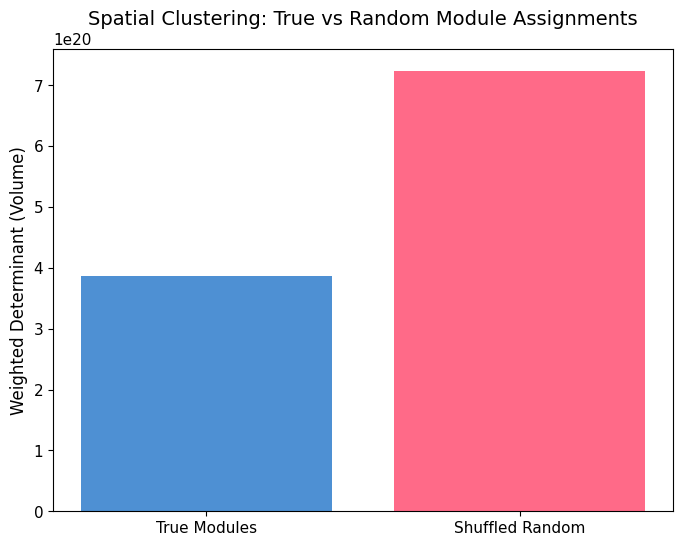

In [69]:
methods = ['True Modules', 'Shuffled Random']
volumes = [results_df['True_Volume'].mean(), results_df['Random_Volume'].mean()]

plt.figure(figsize=(8, 6))
plt.bar(methods, volumes, color=['#4e90d3', '#ff6a88'])
plt.ylabel('Weighted Determinant (Volume)', fontsize=12)
plt.title('Spatial Clustering: True vs Random Module Assignments', fontsize=14)
plt.show()

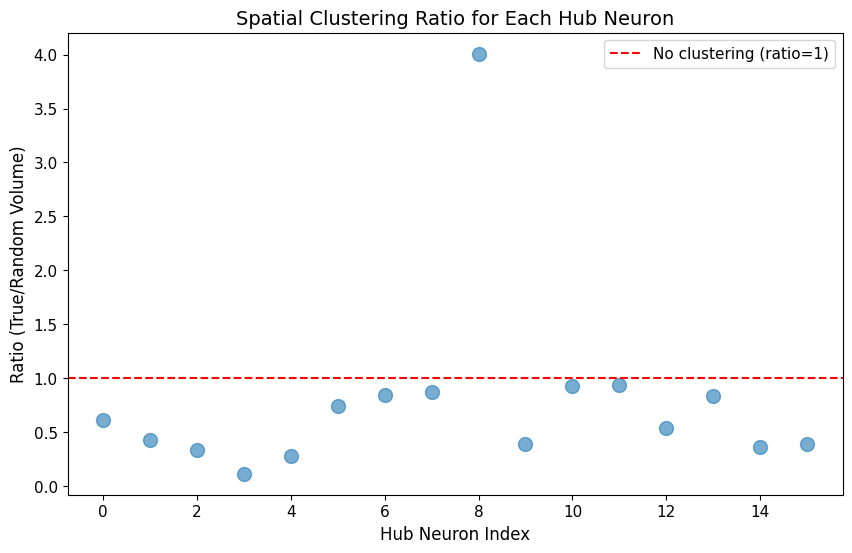

In [70]:
plt.figure(figsize=(10, 6))
plt.scatter(results_df.index, results_df['Ratio'], s=100, alpha=0.6)
plt.axhline(y=1.0, color='red', linestyle='--', label='No clustering (ratio=1)')
plt.xlabel('Hub Neuron Index', fontsize=12)
plt.ylabel('Ratio (True/Random Volume)', fontsize=12)
plt.title('Spatial Clustering Ratio for Each Hub Neuron', fontsize=14)
plt.legend()
plt.show()

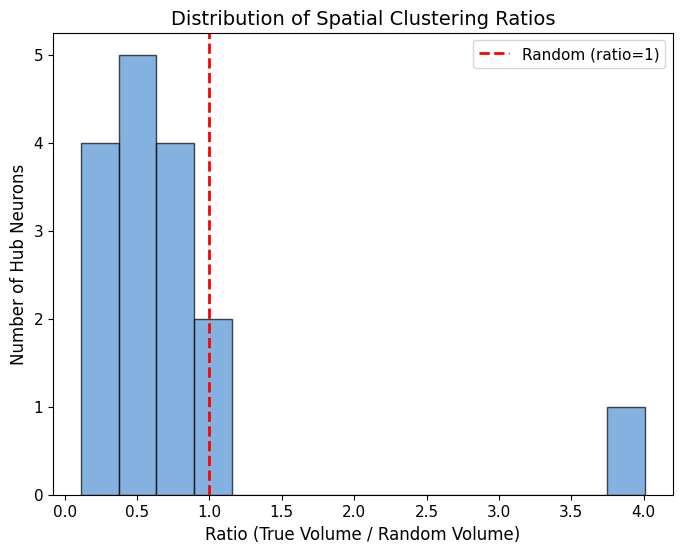

In [71]:
plt.figure(figsize=(8, 6))
plt.hist(results_df['Ratio'], bins=15, color='#4e90d3', alpha=0.7, edgecolor='black')
plt.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Random (ratio=1)')
plt.xlabel('Ratio (True Volume / Random Volume)', fontsize=12)
plt.ylabel('Number of Hub Neurons', fontsize=12)
plt.title('Distribution of Spatial Clustering Ratios', fontsize=14)
plt.legend()
plt.show()

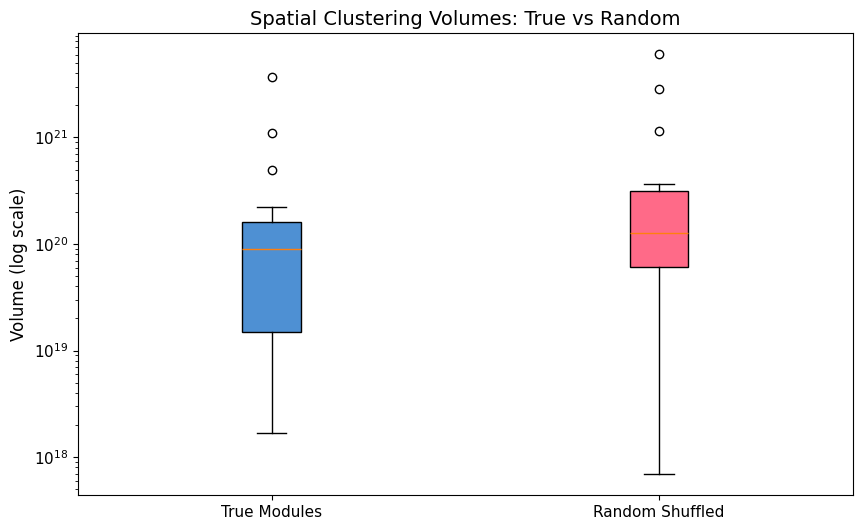

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Box plot
bp = ax.boxplot([results_df['True_Volume'], results_df['Random_Volume']],
                 labels=['True Modules', 'Random Shuffled'],
                 patch_artist=True)

# Color the boxes
colors = ['#4e90d3', '#ff6a88']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_ylabel('Volume (log scale)', fontsize=12)
ax.set_yscale('log')
ax.set_title('Spatial Clustering Volumes: True vs Random', fontsize=14)
plt.show()